In [1]:
#Ｉmport necessary packages
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import xitorch
from xitorch.optimize import rootfinder
import optuna
from torch.utils.data import TensorDataset, DataLoader
import joblib 

# Memory management on GPU
import gc

# Import time
import time

# Testify whether GPU is available
print("Cuda is available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Device is: ", device)

def memory_stats():
    print("Memory allocated: ", torch.cuda.memory_allocated()/1024**2)
    print("Memory cached: ", torch.cuda.memory_reserved()/1024**2)
memory_stats()


/home/shengduo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cuda is available:  True
Device is:  cuda:0
Memory allocated:  0.0
Memory cached:  0.0


In [2]:
# Re-sample from 0112 datasets
dataprefixs = ["Trial0112_smallDRS_Burigede", "Trial0112_smallDRS_smallA"]

# Get 100 entries
for idx, dataprefix in enumerate(dataprefixs):
    dataFile = "./data/" + dataprefix + ".pt"
    shit = torch.load(dataFile)

    # Store the results
    res = dict()

    # Train indices
    train_indices = torch.randperm(160)[0:80]
    res["fs"] = shit["fs"][train_indices]
    res["Vs"] = shit["Vs"][train_indices]
    res["thetas"] = shit["thetas"][train_indices]
    res["ts"] = shit["ts"][train_indices]

    # Test indices
    test_indices = torch.randperm(40)[0:20] + 160
    res["fs"] = torch.concat([res["fs"], shit["fs"][test_indices]], dim = 0)
    res["Vs"] = torch.concat([res["Vs"], shit["Vs"][test_indices]], dim = 0)
    res["thetas"] = torch.concat([res["thetas"], shit["thetas"][test_indices]], dim = 0)
    res["ts"] = torch.concat([res["ts"], shit["ts"][test_indices]], dim = 0)

    combDataFile = "./data/" + dataprefix + "_resampled.pt"
    torch.save(res, combDataFile)

# Merge two datasets

In [7]:
# dataprefixs = ["Trial1215_smallDRS_Burigede", "Trial1215_smallDRS_smallA"]
# dataprefixs = ["Trial1215_smallDRS_Burigede", "Trial0112_smallDRS_Burigede"]
# dataprefixs = ["Trial0112_smallDRS_smallA_resampled", "Trial0112_smallDRS_Burigede_resampled"]
# dataprefixs = ["Trial0112_smallDRS_Burigede", "Trial0216_smallDRS_Burigede"]
# combprefix = "Trial0112_smallDRS_Burigede"
# combprefix = "Trial0216_smallDRS_Burigede_400"

dataprefixs = ["Trial0216_smallDRS_smallA_400", "Trial0216_smallDRS_Burigede_400"]
combprefix = "Trial0216_combined_800"
# dataprefixs = ["Trial0112_smallDRS_Burigede", "Trial0112_smallDRS_smallA"]
# combprefix = "Trial0112_combined"

for idx, dataprefix in enumerate(dataprefixs):
    # Generate / load data
    dataFile = "./data/" + dataprefix + ".pt"

    shit = torch.load(dataFile)
    train_len = int(0.8 * len(shit["Vs"]))
    print(train_len) 
    
    # If this is the first set
    if idx == 0:
        Vs_train = shit["Vs"][:train_len]
        thetas_train = shit["thetas"][:train_len]
        fs_train = shit["fs"][:train_len]
        ts_train = shit["ts"][:train_len]

        Vs_test = shit["Vs"][train_len:]
        thetas_test = shit["thetas"][train_len:]
        fs_test = shit["fs"][train_len:]
        ts_test = shit["ts"][train_len:]

    else:
        Vs_train = torch.cat([Vs_train, shit["Vs"][:train_len]], dim=0)
        thetas_train = torch.cat([thetas_train, shit["thetas"][:train_len]], dim=0)
        fs_train = torch.cat([fs_train, shit["fs"][:train_len]], dim=0)
        ts_train = torch.cat([ts_train, shit["ts"][:train_len]], dim=0)

        Vs_test = torch.cat([Vs_test, shit["Vs"][train_len:]], dim=0)
        thetas_test = torch.cat([thetas_test, shit["thetas"][train_len:]], dim=0)
        fs_test = torch.cat([fs_test, shit["fs"][train_len:]], dim=0)
        ts_test = torch.cat([ts_test, shit["ts"][train_len:]], dim=0)

Vs = torch.cat([Vs_train, Vs_test], dim=0)
thetas = torch.cat([thetas_train, thetas_test], dim=0)
fs = torch.cat([fs_train, fs_test], dim=0)
ts = torch.cat([ts_train, ts_test], dim=0)

# Restore
combSet = {
    "Vs": Vs, 
    "thetas" : thetas, 
    "fs" : fs, 
    "ts" : ts, 
}

# Output
combDataFile = "./data/" + combprefix + ".pt"
torch.save(combSet, combDataFile)

320
320


In [6]:
import optuna

# Trial of loading study
this_study = optuna.load_study(study_name="my_study", 
                               storage="sqlite:///./jobs/Trial0112_smallDRS_Burigede_1.db")

In [7]:
this_study.best_params

{'W_layers': 7,
 'W_layer_units_exponent_0': 8,
 'W_layer_units_exponent_1': 10,
 'W_layer_units_exponent_2': 7,
 'W_layer_units_exponent_3': 5,
 'W_layer_units_exponent_4': 5,
 'W_layer_units_exponent_5': 5,
 'W_layer_units_exponent_6': 7,
 'D_layers': 8,
 'D_layer_units_exponent_0': 10,
 'D_layer_units_exponent_1': 5,
 'D_layer_units_exponent_2': 9,
 'D_layer_units_exponent_3': 6,
 'D_layer_units_exponent_4': 5,
 'D_layer_units_exponent_5': 8,
 'D_layer_units_exponent_6': 4,
 'D_layer_units_exponent_7': 7,
 'D_dagger_layers': 7,
 'D_dagger_layer_units_exponent_0': 6,
 'D_dagger_layer_units_exponent_1': 9,
 'D_dagger_layer_units_exponent_2': 9,
 'D_dagger_layer_units_exponent_3': 9,
 'D_dagger_layer_units_exponent_4': 10,
 'D_dagger_layer_units_exponent_5': 9,
 'D_dagger_layer_units_exponent_6': 6,
 'log_learning_rate': -2.4788242605567268,
 'log_learning_rate_D': -4.080048260166542,
 'log_learning_rate_D_dagger': -4.506701666601625,
 'training_batch_size': 6,
 'training_p': 2}

# Generating using Burigede's scheme

In [4]:
## Generating using Burigede's scheme
from DataGeneration import generateSamples_Burigede
import os
generating_flag = True
beta = [0.011, 0.016, 1. / 1.e-2, 0.58]
kwgs = {
    "beta" : beta,
    "totalNofSeqs" : 200, # 1024 * 16, 
    "NofIntervalsRange" : [3, 5], #[5, 11], 
    "VVRange" : [-2, 1], 
    "VVLenRange" : [3, 4], 
    "Tmax" : 2.0, 
    "nTSteps" : 100, 
    "theta0" : 1. / beta[2], 
    "prefix" : "Trial0216_smallDRS_Burigede", # Used to be 1215
    "NofVVSteps" : 10, 
}



# Generate / load data
dataFile = "./data/" + kwgs["prefix"] + ".pt"

if generating_flag or not(os.path.isfile(dataFile)):
    print("Generating data")
    generateSamples_Burigede(kwgs)

shit = torch.load(dataFile)
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# Now Vs and ts have fixed length
print("Vs.shape: ", Vs.shape)
print("thetas.shape: ", thetas.shape)
print("fs.shape: ", fs.shape)
print("ts.shape: ", ts.shape)
# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Xs, ts)
print("Xs.shape: ", Xs.shape)

Generating data
Vs.shape:  torch.Size([200, 100])
thetas.shape:  torch.Size([200, 100])
fs.shape:  torch.Size([200, 100])
ts.shape:  torch.Size([200, 100])
Xs.shape:  torch.Size([200, 100])


/tmp/ipykernel_1783145/1987264161.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


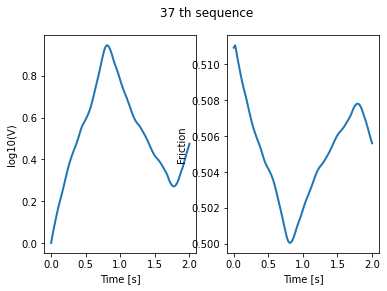

In [3]:
# Plot a sequence
idx = torch.randint(len(Vs), (1, ))[0]
fig, axs = plt.subplots(1, 2)
fig.suptitle("{0} th sequence".format(idx))

axs[0].plot(ts[idx, :], torch.log10(Vs[idx, :]), linewidth=2.0)
axs[0].set(xlabel = "Time [s]", ylabel = "log10(V)")
axs[1].plot(ts[idx, :], fs[idx, :], linewidth=2.0)
axs[1].set(xlabel = "Time [s]", ylabel = "Friction")
fig.show()

In [3]:
# Define MLP for potentials
class ReLUSquare(nn.Module): 
    def __init__(self): 
        super(ReLUSquare, self).__init__() 
        self.fc = nn.ReLU()
  
    def forward(self, x): 
        return torch.pow(self.fc(x), 1)
    
class PP(nn.Module):
    # Constructor
    def __init__(self, NNs, input_dim = 1, output_dim = 1):
        super().__init__()
        self.activation = ReLUSquare()
        
        self.fc = nn.Sequential(
            nn.Linear(input_dim, NNs[0]), 
            self.activation,
        )
        
        for i in range(len(NNs) - 1):
            self.fc.append(nn.Linear(NNs[i], NNs[i + 1]))
            self.fc.append(self.activation)
        
        self.fc.append(nn.Linear(NNs[-1], output_dim))
        self.fc.append(self.activation)
    
    # Forward function
    def forward(self, x):
        return self.fc(x)

# Data generation

In [2]:
from DataGeneration import generateSamples, genVVtt
import os

generating_flag = False
# kwgs = {
#     "beta" : [0.006, 0.012, 1. / 1.e12, 0.58], 
#     "totalNofSeqs" : 100, # 1024 * 16, 
#     "NofIntervalsRange" : [4, 5], #[5, 11], 
#     "VVRange" : [-3, 1], 
#     "VVLenRange" : [3, 4], 
#     "theta0" : 0.1, 
#     "prefix" : "Trial1108_bigDRS_Burigede", 
#     "NofVVSteps" : 10, 
# }
beta = [0.011, 0.016, 1. / 1.e-2, 0.58]
kwgs = {
    "beta" : beta, 
    "totalNofSeqs" : 200, # 1024 * 16, 
    "NofIntervalsRange" : [4, 10], #[5, 11], 
    "VVRange" : [-2, 1], 
    "VVLenRange" : [30, 40], 
    "theta0" : 1. / beta[2], 
    "prefix" : "Trial0216_smallDRS_smallA", # Used to be 1215
    # "prefix" : "Trial1116_smallDRS_largeA", 
    "NofVVSteps" : 10, 
}

# Generate / load data
dataFile = "./data/" + kwgs["prefix"] + ".pt"

if generating_flag or not(os.path.isfile(dataFile)):
    print("Generating data")
    generateSamples(kwgs)

shit = torch.load(dataFile)
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# Stack data as
# Vs = torch.stack(Vs)
# thetas = torch.stack(thetas)
# fs = torch.stack(fs)
# ts = torch.stack(ts)

# Now Vs and ts have fixed length
print("Vs.shape: ", Vs.shape)
print("thetas.shape: ", thetas.shape)
print("fs.shape: ", fs.shape)
print("ts.shape: ", ts.shape)
# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Xs, ts)
print("Xs.shape: ", Xs.shape)

Generating data
VVFirst =  1.0
Maximum VV length:  tensor(10)
Minimum VV length:  tensor(10)
JumpIdx:  [0, 1, 5, 6, 9]
JumpIdx:  [0, 9]
JumpIdx:  [0, 4, 5, 9]
JumpIdx:  [0, 5, 6, 7, 8, 9]
JumpIdx:  [0, 1, 2, 8, 9]
JumpIdx:  [0, 1, 2, 3, 9]
JumpIdx:  [0, 1, 2, 5, 6, 9]
JumpIdx:  [0, 1, 2, 3, 9]
JumpIdx:  [0, 1, 2, 3, 4, 6, 7, 8, 9]
JumpIdx:  [0, 1, 9]
JumpIdx:  [0, 1, 2, 9]
JumpIdx:  [0, 1, 2, 7, 8, 9]
JumpIdx:  [0, 2, 3, 4, 5, 7, 8, 9]
JumpIdx:  [0, 1, 2, 9]
JumpIdx:  [0, 5, 6, 9]
JumpIdx:  [0, 1, 4, 5, 6, 7, 8, 9]
JumpIdx:  [0, 9]
JumpIdx:  [0, 1, 2, 3, 5, 9]
JumpIdx:  [0, 1, 9]
JumpIdx:  [0, 5, 9]
JumpIdx:  [0, 1, 2, 3, 6, 7, 8, 9]
JumpIdx:  [0, 1, 4, 5, 6, 9]
JumpIdx:  [0, 1, 3, 9]
JumpIdx:  [0, 1, 8, 9]
JumpIdx:  [0, 9]
JumpIdx:  [0, 2, 3, 4, 5, 9]
JumpIdx:  [0, 1, 2, 3, 7, 9]
JumpIdx:  [0, 1, 9]
JumpIdx:  [0, 1, 2, 3, 4, 5, 9]
JumpIdx:  [0, 1, 4, 6, 7, 9]
JumpIdx:  [0, 3, 4, 6, 7, 9]
JumpIdx:  [0, 4, 5, 6, 7, 9]
JumpIdx:  [0, 1, 6, 7, 9]
JumpIdx:  [0, 7, 8, 9]
JumpIdx:  [0, 1, 4, 

/tmp/ipykernel_1783145/3977903667.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


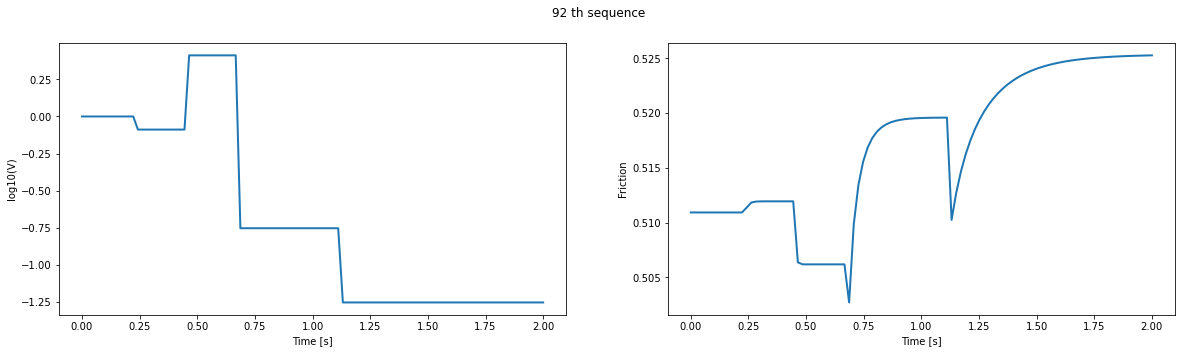

In [6]:
# Plot a sequence
idx = torch.randint(len(Vs), (1, ))[0]
fig, axs = plt.subplots(1, 2, figsize = [20, 5])
fig.suptitle("{0} th sequence".format(idx))

axs[0].plot(ts[idx, :], torch.log10(Vs[idx, :]), linewidth=2.0)
axs[0].set(xlabel = "Time [s]", ylabel = "log10(V)")
axs[1].plot(ts[idx, :], fs[idx, :], linewidth=2.0)
axs[1].set(xlabel = "Time [s]", ylabel = "Friction")
fig.show()

In [39]:
torch.sign(torch.tensor(-1.0))

tensor(-1.)

# Defining NNs, for $W (V, \xi)$ and $D (V, \xi, \dot{\xi})$

# Calculate $f = \partial W / \partial V$, $\xi_{n+1}$ such that $\partial D / \partial \dot{\xi} + \partial W / \partial \xi = 0$

In [5]:
# Define class for training and calculating f
# Optimizer Adams
import torch.optim as optim

class PotentialsFric:
    # Initialization of W and D
    def __init__(self, kwgsPot):
        self.dim_xi = kwgsPot["dim_xi"]
        self.NNs_W = kwgsPot["NNs_W"]
        self.NNs_D = kwgsPot["NNs_D"]
        self.W = PP(self.NNs_W, input_dim = 1 + self.dim_xi, output_dim = 1)
        # self.D = PP(self.NNs_D, input_dim = 1 + 2 * self.dim_xi, output_dim = 1)
        self.optim_W = optim.Adam(self.W.parameters(), lr=kwgsPot["learning_rate"])
        # self.optim_D = optim.Adam(self.D.parameters(), lr=0.001)
        
        # Device
        self.device = kwgsPot["device"]
        self.W.to(self.device)
        
    # Calculate f 
    def calf(self, x, t):
        # Initialize Vs
        batch_size = x.shape[0]
        time_steps = x.shape[1]
        # xis[:, :, :] = 1. 
        
        
        # Loop through time steps
        
        if self.dim_xi > 0:
            xi0 = torch.zeros([batch_size, self.dim_xi], requires_grad=True, device=self.device)
            
            # List of fs
            list_fs = []
            list_xis = [xi0]
            
            for idx in range(x.shape[1]):
                # f = \partial W / \partial V
                X_W = torch.concat([x[:, idx:idx + 1], list_xis[-1]], dim = 1).requires_grad_()
                # X_W.to(self.device)
                W = torch.sum(self.W(X_W))

                this_piece = torch.autograd.grad(outputs=W, inputs=X_W, create_graph=True)[0]
                list_fs.append(this_piece[:, 0:1])

                # Solve for \dot{\xi} + \partial W / \partial \xi = 0
                dWdXi = this_piece[:, 1:]

                # XiDot = -dWdXi
                if idx < x.shape[1] - 1:
                    xiNext = list_xis[-1] - dWdXi * (t[:, idx + 1:idx + 2] - t[:, idx:idx + 1]) 
                    list_xis.append(xiNext)
                    
                self.fs = torch.concat(list_fs, dim=1)
        else:
            X_W = x.clone().reshape([x.shape[0], x.shape[1], 1]).requires_grad_()
            # print(X_W)
            W = torch.sum(self.W(X_W))
            self.fs = torch.autograd.grad(outputs=W, inputs=X_W, create_graph=True)[0].reshape([x.shape[0], x.shape[1]])
            # print('self.fs.shape: ', self.fs.shape)
            
            

In [6]:
# Different Potentials with D correction
import torch.optim as optim
## Calculate f
# Different Potentials with D correction
class PotentialsFricCorrection:
    # Initialization of W and D
    def __init__(self, kwgsPot):
        self.dim_xi = kwgsPot["dim_xi"]
        self.NNs_W = kwgsPot["NNs_W"]
        self.NNs_D = kwgsPot["NNs_D"]
        self.NNs_D_dagger = kwgsPot["NNs_D_dagger"]
        self.W = PP(self.NNs_W, input_dim = 1 + self.dim_xi, output_dim = 1)
        self.D = PP(self.NNs_D, input_dim = self.dim_xi, output_dim = 1)
        self.D_dagger = PP(self.NNs_D_dagger, input_dim = 1, output_dim = 1)
        self.optim_W = optim.Adam(self.W.parameters(), lr=kwgsPot["learning_rate"])
        self.optim_D = optim.Adam(self.D.parameters(), lr=kwgsPot["learning_rate_D"])
        self.optim_D_dagger = optim.Adam(self.D_dagger.parameters(), lr=kwgsPot["learning_rate_D_dagger"])
        
        # Device
        self.device = kwgsPot["device"]
        self.W.to(self.device)
        self.D.to(self.device)
        self.D_dagger.to(self.device)
        
    # Calculate f 
    def calf(self, x, xDot, t):
        # Initialize Vs
        batch_size = x.shape[0]
        time_steps = x.shape[1]
        # xis[:, :, :] = 1. 
        
        
        # Loop through time steps
        
        if self.dim_xi > 0:
            xi0 = torch.zeros([batch_size, self.dim_xi], requires_grad=True, device=self.device)
            
            # List of fs
            list_fs = []
            list_xis = [xi0]
            
            for idx in range(x.shape[1]):
                # f = \partial W / \partial V
                X_W = torch.concat([x[:, idx:idx + 1], list_xis[-1]], dim = 1).requires_grad_()
                # X_W.to(self.device)
                W = torch.sum(self.W(X_W))

                this_piece = torch.autograd.grad(outputs=W, inputs=X_W, create_graph=True)[0]

                # Solve for \dot{\xi} + \partial W / \partial \xi = 0
                dWdXi = this_piece[:, 1:]

                X_D_dagger = xDot[:, idx:idx+1].requires_grad_()
                D_dagger = torch.sum(self.D_dagger(X_D_dagger))
                dD_daggerdXDot = torch.autograd.grad(outputs=D_dagger, inputs=X_D_dagger, create_graph=True)[0]

                list_fs.append(this_piece[:, 0:1] + dD_daggerdXDot.reshape([-1, 1]))

                # XiDot = -dWdXi
                if idx < x.shape[1] - 1:
                    this_input = -dWdXi.clone().requires_grad_()
                    D = torch.sum(self.D(this_input))
                    xiNext = list_xis[-1] + torch.autograd.grad(outputs=D, inputs=this_input, create_graph=True)[0] * (t[:, idx + 1:idx + 2] - t[:, idx:idx + 1])
                    list_xis.append(xiNext)
                    
                    del this_input, W, dWdXi, X_W, D, this_piece, dD_daggerdXDot, X_D_dagger, D_dagger 
                    
                self.fs = torch.concat(list_fs, dim=1)
        else:
            X_W = x.clone().reshape([x.shape[0], x.shape[1], 1]).requires_grad_()
            # print(X_W)
            W = torch.sum(self.W(X_W))

            X_D_dagger = xDot.clone().reshape([xDot.shape[0], xDot.shape[1], 1]).requires_grad_()
            D_dagger = torch.sum(self.D_dagger(X_D_dagger))
            self.fs = torch.autograd.grad(outputs=W, inputs=X_W, create_graph=True)[0].reshape([x.shape[0], x.shape[1]]) \
                      + torch.autograd.grad(outputs=D_dagger, inputs=X_D_dagger, create_graph=True)[0].reshape([xDot.shape[0], xDot.shape[1]])
            del W, X_W, X_D_dagger, D_dagger 
            
## Define loss function, training function, dataloaders
# Define loss functions given fs_targ, fs. 
def Loss(fs_targ, fs, ts, p = 2):
    err = torch.trapz(torch.abs(fs_targ - fs) ** p, ts, dim = 1) / torch.trapz(torch.abs(fs_targ) ** p, ts, dim = 1)
    err = torch.pow(err, 1. / p)
    return torch.sum(err)

# Training for one epoch
def train1Epoch(data_loader, loss_fn, myPot, p, update_weights=True):
    # Record of losses for each batch
    Losses = []
    device=myPot.device
    
    # Enumerate over data_loader
    for idx, (Xs, XDots, ts, fs_targ) in enumerate(data_loader):
        # Send shits to GPU
        Xs = Xs.to(device)
        XDots = XDots.to(device)
        ts = ts.to(device)
        fs_targ = fs_targ.to(device)
        
        # Refresh the optimizers
        myPot.optim_W.zero_grad()
        
        if hasattr(myPot, 'optim_D'):
            myPot.optim_D.zero_grad()
        
        if hasattr(myPot, 'optim_D_dagger'):
            myPot.optim_D_dagger.zero_grad()
        
        ## DEBUG LINE CHECK DEVICES
        # print("Xs.device: ", Xs.device)
        # print("Xs[:, 0:1].device: ", Xs[:, 0:1].device)
        
        # Compute loss
        myPot.calf(Xs, XDots, ts)
        loss = loss_fn(fs_targ, myPot.fs, ts, p)
        Losses.append(loss)
        
        # Update the model parameters
        if update_weights:
            loss.backward()
            myPot.optim_W.step()
        
            if hasattr(myPot, 'optim_D'):
                myPot.optim_D.step()
            
            if hasattr(myPot, 'optim_D_dagger'):
                myPot.optim_D_dagger.step()

        
        
    res = sum(Losses) / len(data_loader.dataset)
    # print("Memory before del in train1Epoch: ")
    # memory_stats()

    del Xs, XDots, ts, fs_targ, Losses
    torch.cuda.empty_cache()

    # print("Memory after del in train1Epoch: ")
    # memory_stats()
    return res

# Initialize dataloaders
AllData = TensorDataset(
    Xs, 
    Vs, 
    ts, 
    fs
)

dataloader_kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)

train_len = int(len(Vs) * 0.8)
test_len = len(Vs) - train_len
# trainDataset, testDataset = torch.utils.data.random_split(AllData, [train_len, test_len])
# Created using indices from 0 to train_size.
trainDataset = torch.utils.data.Subset(AllData, range(train_len))

# Created using indices from train_size to train_size + test_size.
testDataset = torch.utils.data.Subset(AllData, range(train_len, train_len + test_len))

# Train using tuned parameters

# Make an optuna function

In [7]:
class OptunaObj:
    # Initialize
    def __init__(self, kwgs):
        self.dim_xi = kwgs['dim_xi']
        self.test_p = kwgs['test_p']
        self.test_batch_size = kwgs['test_batch_size']
        self.device = kwgs['device']
        self.training_dataset = kwgs['training_dataset']
        self.test_dataset = kwgs['test_dataset']
        self.modelSavePrefix = kwgs['modelSavePrefix']
        
        
    # Define the objective
    def objective(self, trial):
        # Dump for un-saved interuptions
        joblib.dump(this_study, "./data/1108_bigDRS_Burigede_WDsep_study_dim_xi_logV_DLeg_D_dagger_ELU1_" + str(self.dim_xi) + ".pkl")

        # Fixed parameters
        dim_xi = self.dim_xi
        NNs_D = []
        test_p = self.test_p
        test_batch_size = self.test_batch_size

        # Define NN for W
        W_layers = trial.suggest_int('W_layers', 2, 8)
        NNs_W = []
        for i in range(W_layers):
            this_W = 2 ** trial.suggest_int('W_layer_units_exponent_{}'.format(i), 4, 10)
            NNs_W.append(this_W)
            
        # Define NN for D
        D_layers = trial.suggest_int('D_layers', 2, 8)
        NNs_D = []
        for i in range(D_layers):
            this_D = 2 ** trial.suggest_int('D_layer_units_exponent_{}'.format(i), 4, 10)
            NNs_D.append(this_D)
        
        # Define NN for D_dagger
        D_dagger_layers = trial.suggest_int('D_dagger_layers', 2, 8)
        NNs_D_dagger = []
        for i in range(D_dagger_layers):
            this_D_dagger = 2 ** trial.suggest_int('D_dagger_layer_units_exponent_{}'.format(i), 4, 10)
            NNs_D_dagger.append(this_D_dagger)

        # Suggest learning rate
        learning_rate = 10 ** trial.suggest_float('log_learning_rate', -5., -1.)
        
        # Suggest learning rate for D
        learning_rate_D = 10 ** trial.suggest_float('log_learning_rate_D', -5., -1.)

        # Suggest learning rate for D
        learning_rate_D_dagger = 10 ** trial.suggest_float('log_learning_rate_D_dagger', -5., -1.)

        # Suggest batchsize
        training_batch_size = 2 ** trial.suggest_int('training_batch_size', 6, 12)

        # Suggest training p
        training_p = trial.suggest_int('training_p', 2, 8)

        # Suggest training epochs
        # training_epochs = 2 ** trial.suggest_int('training_epoch_exponents', 5, 9)
        training_epochs = 100

        params = {
            'dim_xi' : dim_xi, 
            'NNs_W' : NNs_W, 
            'NNs_D' : NNs_D, 
            'NNs_D_dagger' : NNs_D_dagger, 
            'learning_rate' : learning_rate, 
            'learning_rate_D' : learning_rate_D, 
            'learning_rate_D_dagger' : learning_rate_D_dagger,  
            'training_batch_size' : training_batch_size, 
            'training_p' : training_p, 
            'training_epochs' : training_epochs, 
            'device' : self.device,
        }
        
        
        # Set training dataloader
        training_batch_size = params['training_batch_size'] #1024
        trainDataLoader = DataLoader(
            self.training_dataset,
            batch_size = training_batch_size,
            shuffle = True,
        #    num_workers = 16,
            collate_fn = None,
            **dataloader_kwargs, 
        )

        # Set testing data loader
        testing_batch_size = self.test_batch_size # 256
        testDataLoader = DataLoader(
            self.test_dataset,
            batch_size = testing_batch_size,
            shuffle = True,
        #    num_workers = 16,
            collate_fn = None,
            **dataloader_kwargs, 
        )
        
        # Print out info
        print("-"*20, " Trial ", str(trial.number), " ", "-"*20, flush=True)
        st = time.time()
        print("Start timing: ")
        
        print("Parameters: ", flush=True)
        print(trial.params, flush=True)
        
        # Training
        myWD = PotentialsFricCorrection(params)
        for i in range(params['training_epochs']):
            avg_training_loss = train1Epoch(trainDataLoader, Loss, myWD, params['training_p'])
            
            if torch.isnan(avg_training_loss):
                break
            
            if i % 10 == 0:
                # avg_test_loss = train1Epoch(testDataLoader, Loss, myWD, self.test_p, update_weights=False)
                print("\t", "epoch ", str(i), "training error: ", str(avg_training_loss), flush=True)
                ## Print memory status
                print("Memory status after this epoch: ")
                memory_stats()
        
        # Return objective value for optuna
        res = train1Epoch(testDataLoader, Loss, myWD, self.test_p, update_weights=False)
        if len([this_study.trials]) == 1 or res < this_study.best_value:
            torch.save(myWD, './model/' + self.modelSavePrefix + '_model.pth')
        print("Time for this trial: ", time.time() - st)
        # Release GPU memory
        del myWD
        gc.collect()
        torch.cuda.empty_cache()
        
        ## Print memory status
        print("Memory status after this trial: ")
        memory_stats()
        
        return res

In [8]:
class PotentialsFricCorrectionNoDagger:
    # Initialization of W and D
    def __init__(self, kwgsPot):
        self.dim_xi = kwgsPot["dim_xi"]
        self.NNs_W = kwgsPot["NNs_W"]
        self.NNs_D = kwgsPot["NNs_D"]

        self.W = PP(self.NNs_W, input_dim = 1 + self.dim_xi, output_dim = 1)
        self.D = PP(self.NNs_D, input_dim = self.dim_xi, output_dim = 1)

        self.optim_W = optim.Adam(self.W.parameters(), lr=kwgsPot["learning_rate"])
        self.optim_D = optim.Adam(self.D.parameters(), lr=kwgsPot["learning_rate_D"])

        
        # Device
        self.device = kwgsPot["device"]
        self.W.to(self.device)
        self.D.to(self.device)

        
    # Calculate f 
    def calf(self, x, xDot, t):
        # Initialize Vs
        batch_size = x.shape[0]
        time_steps = x.shape[1]
        # xis[:, :, :] = 1. 
        
        
        # Loop through time steps
        
        if self.dim_xi > 0:
            xi0 = torch.zeros([batch_size, self.dim_xi], requires_grad=True, device=self.device)
            
            # List of fs
            list_fs = []
            list_xis = [xi0]
            
            for idx in range(x.shape[1]):
                # f = \partial W / \partial V
                X_W = torch.concat([x[:, idx:idx + 1], list_xis[-1]], dim = 1).requires_grad_()
                # X_W.to(self.device)
                W = torch.sum(self.W(X_W))

                this_piece = torch.autograd.grad(outputs=W, inputs=X_W, create_graph=True)[0]

                # Solve for \dot{\xi} + \partial W / \partial \xi = 0
                dWdXi = this_piece[:, 1:]

                list_fs.append(this_piece[:, 0:1])

                # XiDot = -dWdXi
                if idx < x.shape[1] - 1:
                    this_input = -dWdXi.clone().requires_grad_()
                    D = torch.sum(self.D(this_input))
                    xiNext = list_xis[-1] + torch.autograd.grad(outputs=D, inputs=this_input, create_graph=True)[0] * (t[:, idx + 1:idx + 2] - t[:, idx:idx + 1])
                    list_xis.append(xiNext)
                    
                    del this_input, W, dWdXi, X_W, D, this_piece
                    
                self.fs = torch.concat(list_fs, dim=1)
        else:
            X_W = x.clone().reshape([x.shape[0], x.shape[1], 1]).requires_grad_()
            # print(X_W)
            W = torch.sum(self.W(X_W))


            self.fs = torch.autograd.grad(outputs=W, inputs=X_W, create_graph=True)[0].reshape([x.shape[0], x.shape[1]])
            del W, X_W

def totalTestError(data_loader, loss_fn, myPots, p):
    # Record of losses for each batch
    Losses = []
    device=myPots[0].device
    
    # Enumerate over data_loader
    for idx, (Xs, XDots, ts, fs_targ) in enumerate(data_loader):
        # Send shits to GPU
        Xs = Xs.to(device)
        XDots = XDots.to(device)
        ts = ts.to(device)
        fs_targ = fs_targ.to(device)

        ## DEBUG LINE CHECK DEVICES
        # print("Xs.device: ", Xs.device)
        # print("Xs[:, 0:1].device: ", Xs[:, 0:1].device)
        
        # Compute loss
        fs = torch.zeros(fs_targ.shape, device=device)

        for myPot in myPots:
            myPot.calf(Xs, XDots, ts)
            fs = fs + myPot.fs
        
        loss = loss_fn(fs_targ, fs, ts, p)

        # DEBUG LINE
        # loss1 = Loss1(fs_targ, fs, ts, p)
        
        Losses.append(loss)
    
    # print("Losses: ", Losses)
    # print("loss1: ", loss1)
    # print("sum(Losses): ", sum(Losses))

    # print("len(data_loader.dataset): ", len(data_loader.dataset))  
    
    res = sum(Losses) / len(data_loader.dataset)
    # print("Memory before del in train1Epoch: ")
    # memory_stats()

    del Xs, XDots, ts, fs_targ, Losses, fs
    torch.cuda.empty_cache()

    # print("Memory after del in train1Epoch: ")
    # memory_stats()

    return res

In [10]:
# model_base = torch.load('./model/Trial1116_bigDRS_Burigede_dim_xi_0_model.pth')
# model_base = torch.load('./model/Trial1116_smallDRS_dim_xi_0_model.pth')
# model_base = torch.load('./model/Trial1116_smallDRS_withOffSet_dim_xi_0_model.pth')
model_base = torch.load('./model/Trial1117_smallDRS_Burigede_largeA_dim_xi_0_model.pth')

In [11]:
dim_xis = [1]
model_corrections = []
for dim_xi in dim_xis:
    # model_correction = torch.load('./model/Trial1116_bigDRS_Burigede_dim_xi_{0}_model.pth'.format(dim_xi))
    # model_correction = torch.load('./model/Trial1116_smallDRS_dim_xi_{0}_model.pth'.format(dim_xi))
    # model_correction = torch.load('./model/Trial1116_smallDRS_withOffSet_dim_xi_{0}_model.pth'.format(dim_xi))
    model_correction = torch.load('./model/Trial1117_smallDRS_Burigede_largeA_dim_xi_{0}_model.pth'.format(dim_xi))
    model_corrections.append(model_correction)

In [12]:
def Loss1(fs_targ, fs, ts, p = 2):
    err = torch.trapz(torch.abs(fs_targ - fs) ** p, ts, dim = 1) / torch.trapz(torch.abs(fs_targ) ** p, ts, dim = 1)
    err = torch.pow(err, 1. / p)
    return err, torch.sum(err)


# model_base = torch.load('./model/Trial1108_bigDRS_Burigede_dim_xi_0_model.pth')
# model_correction = torch.load('./model/Trial1108_bigDRS_Burigede_dim_xi_{0}_model.pth'.format(dim_xi))

# Set testing data loader
testing_batch_size = len(testDataset) # 256
testDataLoader = DataLoader(
    testDataset,
    batch_size = testing_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    **dataloader_kwargs, 
)

res_base = totalTestError(testDataLoader, Loss, [model_base], 2)
print("Test loss with no xi: ", res_base)

for idx, model_correction in enumerate(model_corrections):
    res_corr = totalTestError(testDataLoader, Loss, [model_base, model_correction], 2)
    print("Test loss with xi = {0}: ".format(dim_xis[idx]), res_corr)

this_Xs = torch.stack([testDataset[i][0] for i in range(len(testDataset))], dim=0)
this_Vs = torch.stack([testDataset[i][1] for i in range(len(testDataset))], dim=0)
this_ts = torch.stack([testDataset[i][2] for i in range(len(testDataset))], dim=0)
this_fs = torch.stack([testDataset[i][3] for i in range(len(testDataset))], dim=0)
this_Xs = this_Xs.to(device)
this_Vs = this_Vs.to(device)
this_ts = this_ts.to(device)
this_fs = this_fs.to(device)

model_base.calf(this_Xs, this_Vs, this_ts)
this_f_preds_base = model_base.fs.to("cpu").detach()
this_f_preds_withCorrections = []

for model_correction in model_corrections:
    model_correction.calf(this_Xs, this_Vs, this_ts)
    this_f_preds_withCorrection = this_f_preds_base + model_correction.fs.to("cpu").detach()
    this_f_preds_withCorrections.append(this_f_preds_withCorrection)

this_Xs = this_Xs.to("cpu")
this_Vs = this_Vs.to("cpu")
this_ts = this_ts.to("cpu")
this_fs = this_fs.to("cpu")

# Plot a fitted sequence
def cal_Loss(f, f_targ, t, p=2):
    return torch.pow(
        torch.trapezoid(torch.pow(torch.abs(f - f_targ), p), t) / torch.trapezoid(torch.pow(torch.abs(f_targ), p), t), 
        1./ p
    )

# ## DEBUG LINES
# loss0 = []
# loss1 = []
# loss2 = []
# for idx in range(len(testDataset)):
#     this_loss = cal_Loss(this_f_preds_base[idx, :], this_fs[idx, :], this_ts[idx, :])
#     loss0.append(this_loss)
#     for dim_xi, this_f_preds_withCorrection in zip(dim_xis, this_f_preds_withCorrections):
#         this_loss = cal_Loss(this_f_preds_withCorrection[idx, :], this_fs[idx, :], this_ts[idx, :])
#         if dim_xi == 1:
#             loss1.append(this_loss)
#         elif dim_xi == 2:
#             loss2.append(this_loss)
# print("avg_error with dim xi = 0: ", torch.stack(loss0).mean())
# # ("avg_error with dim xi = 1: ", torch.stack(loss1).mean())
# print("avg_error with dim xi = 2: ", torch.stack(loss2).mean())
# # model_base

Test loss with no xi:  tensor(0.1922, device='cuda:0', grad_fn=<DivBackward0>)
Test loss with xi = 1:  tensor(0.1914, device='cuda:0', grad_fn=<DivBackward0>)


[Text(0.5, 0, 'Time [s]'), Text(0, 0.5, 'Friction')]

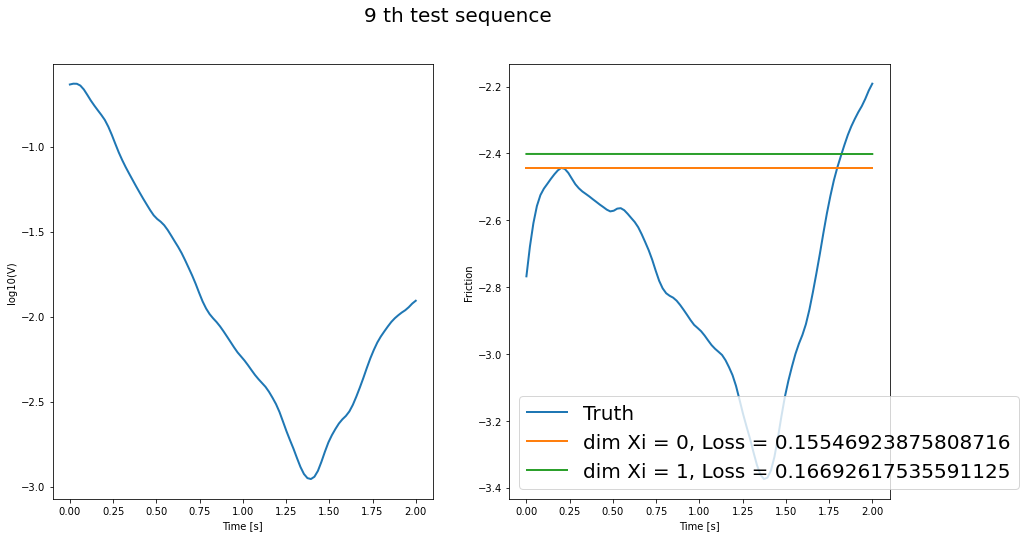

In [18]:
idx = torch.randint(len(testDataset), (1, ))[0]
# idx = 19
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("{0} th test sequence".format(idx), fontsize=20)

axs[0].plot(this_ts[idx, :], torch.log10(this_Vs[idx, :]), linewidth=2.0)
axs[0].set(xlabel = "Time [s]", ylabel = "log10(V)")
this_loss = cal_Loss(this_f_preds_base[idx, :], this_fs[idx, :], this_ts[idx, :])

axs[1].plot(this_ts[idx, :], this_fs[idx, :], linewidth=2.0, label='Truth')
axs[1].plot(this_ts[idx, :], this_f_preds_base[idx, :], linewidth=2.0, label='dim Xi = 0, Loss = {0}'.format(this_loss))

for dim_xi, this_f_preds_withCorrection in zip(dim_xis, this_f_preds_withCorrections):
    this_loss = cal_Loss(this_f_preds_withCorrection[idx, :], this_fs[idx, :], this_ts[idx, :])
    axs[1].plot(this_ts[idx, :], this_f_preds_withCorrection[idx, :], linewidth=2.0, label='dim Xi = {0}, Loss = {1}'.format(dim_xi, this_loss))
axs[1].legend(fontsize=20)
# axs[1].set_ylim(0., 0.2)
axs[1].set(xlabel = "Time [s]", ylabel = "Friction")
# fig.show()

In [73]:
# Do a parametric study over number of hidden parameters
dim_xis = [1, 2, 4]
studys = []

# Tune parameters for dim_xi = 4
OptKwgs = {
    'dim_xi' : 4, 
    'test_p' : 2, 
    'test_batch_size' : len(testDataset), 
    'device' : device, 
    'training_dataset' : trainDataset, 
    'test_dataset' : testDataset, 
}

# Loop through all dim_xis
for dim_xi in dim_xis:
    OptKwgs['dim_xi'] = dim_xi
    myOpt = OptunaObj(OptKwgs)
    this_study = optuna.create_study(direction='minimize')
    this_study.optimize(myOpt.objective, n_trials=50)
    studys.append(this_study)


[I 2023-10-30 10:59:17,646] A new study created in memory with name: no-name-55a528a7-5a6d-4b8f-a6d4-8ed063f4b3a8


--------------------  Trial  0   --------------------
Start timing: 
Parameters: 
{'W_layers': 2, 'W_layer_units_exponent_0': 10, 'W_layer_units_exponent_1': 4, 'D_layers': 4, 'D_layer_units_exponent_0': 9, 'D_layer_units_exponent_1': 6, 'D_layer_units_exponent_2': 5, 'D_layer_units_exponent_3': 6, 'log_learning_rate': -4.1692635687153174, 'log_learning_rate_D': -3.943479524478725, 'training_batch_size': 8, 'training_p': 7}
	 epoch  0 training error:  tensor(0.9974, device='cuda:0', grad_fn=<DivBackward0>)
Memory status after this epoch: 
Memory allocated:  0.9228515625
Memory cached:  10.0


[I 2023-10-30 10:59:20,707] Trial 0 finished with value: 0.9935060739517212 and parameters: {'W_layers': 2, 'W_layer_units_exponent_0': 10, 'W_layer_units_exponent_1': 4, 'D_layers': 4, 'D_layer_units_exponent_0': 9, 'D_layer_units_exponent_1': 6, 'D_layer_units_exponent_2': 5, 'D_layer_units_exponent_3': 6, 'log_learning_rate': -4.1692635687153174, 'log_learning_rate_D': -3.943479524478725, 'training_batch_size': 8, 'training_p': 7}. Best is trial 0 with value: 0.9935060739517212.


Time for this trial:  2.860752582550049
Memory status after this trial: 
Memory allocated:  66.08251953125
Memory cached:  68.0
--------------------  Trial  1   --------------------
Start timing: 
Parameters: 
{'W_layers': 2, 'W_layer_units_exponent_0': 8, 'W_layer_units_exponent_1': 9, 'D_layers': 4, 'D_layer_units_exponent_0': 9, 'D_layer_units_exponent_1': 6, 'D_layer_units_exponent_2': 7, 'D_layer_units_exponent_3': 5, 'log_learning_rate': -4.953928753686283, 'log_learning_rate_D': -2.8408674935462903, 'training_batch_size': 8, 'training_p': 7}
	 epoch  0 training error:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Memory status after this epoch: 
Memory allocated:  2.7744140625
Memory cached:  10.0


[I 2023-10-30 10:59:23,767] Trial 1 finished with value: 1.0 and parameters: {'W_layers': 2, 'W_layer_units_exponent_0': 8, 'W_layer_units_exponent_1': 9, 'D_layers': 4, 'D_layer_units_exponent_0': 9, 'D_layer_units_exponent_1': 6, 'D_layer_units_exponent_2': 7, 'D_layer_units_exponent_3': 5, 'log_learning_rate': -4.953928753686283, 'log_learning_rate_D': -2.8408674935462903, 'training_batch_size': 8, 'training_p': 7}. Best is trial 0 with value: 0.9935060739517212.


Time for this trial:  2.8476054668426514
Memory status after this trial: 
Memory allocated:  58.92724609375
Memory cached:  62.0
--------------------  Trial  2   --------------------
Start timing: 
Parameters: 
{'W_layers': 4, 'W_layer_units_exponent_0': 8, 'W_layer_units_exponent_1': 7, 'W_layer_units_exponent_2': 8, 'W_layer_units_exponent_3': 8, 'D_layers': 5, 'D_layer_units_exponent_0': 6, 'D_layer_units_exponent_1': 9, 'D_layer_units_exponent_2': 7, 'D_layer_units_exponent_3': 5, 'D_layer_units_exponent_4': 9, 'log_learning_rate': -1.4830159122995714, 'log_learning_rate_D': -2.9773368289718154, 'training_batch_size': 12, 'training_p': 3}
	 epoch  0 training error:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Memory status after this epoch: 
Memory allocated:  3.9052734375
Memory cached:  14.0


[I 2023-10-30 10:59:27,447] Trial 2 finished with value: 1.0 and parameters: {'W_layers': 4, 'W_layer_units_exponent_0': 8, 'W_layer_units_exponent_1': 7, 'W_layer_units_exponent_2': 8, 'W_layer_units_exponent_3': 8, 'D_layers': 5, 'D_layer_units_exponent_0': 6, 'D_layer_units_exponent_1': 9, 'D_layer_units_exponent_2': 7, 'D_layer_units_exponent_3': 5, 'D_layer_units_exponent_4': 9, 'log_learning_rate': -1.4830159122995714, 'log_learning_rate_D': -2.9773368289718154, 'training_batch_size': 12, 'training_p': 3}. Best is trial 0 with value: 0.9935060739517212.


Time for this trial:  3.4712066650390625
Memory status after this trial: 
Memory allocated:  83.71142578125
Memory cached:  86.0
--------------------  Trial  3   --------------------
Start timing: 
Parameters: 
{'W_layers': 5, 'W_layer_units_exponent_0': 6, 'W_layer_units_exponent_1': 4, 'W_layer_units_exponent_2': 7, 'W_layer_units_exponent_3': 10, 'W_layer_units_exponent_4': 4, 'D_layers': 2, 'D_layer_units_exponent_0': 4, 'D_layer_units_exponent_1': 4, 'log_learning_rate': -4.959726753797687, 'log_learning_rate_D': -4.032495564579246, 'training_batch_size': 10, 'training_p': 4}
	 epoch  0 training error:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Memory status after this epoch: 
Memory allocated:  2.3720703125
Memory cached:  6.0


[I 2023-10-30 10:59:30,711] Trial 3 finished with value: 1.0 and parameters: {'W_layers': 5, 'W_layer_units_exponent_0': 6, 'W_layer_units_exponent_1': 4, 'W_layer_units_exponent_2': 7, 'W_layer_units_exponent_3': 10, 'W_layer_units_exponent_4': 4, 'D_layers': 2, 'D_layer_units_exponent_0': 4, 'D_layer_units_exponent_1': 4, 'log_learning_rate': -4.959726753797687, 'log_learning_rate_D': -4.032495564579246, 'training_batch_size': 10, 'training_p': 4}. Best is trial 0 with value: 0.9935060739517212.


Time for this trial:  3.0563535690307617
Memory status after this trial: 
Memory allocated:  50.935546875
Memory cached:  54.0
--------------------  Trial  4   --------------------
Start timing: 
Parameters: 
{'W_layers': 5, 'W_layer_units_exponent_0': 10, 'W_layer_units_exponent_1': 10, 'W_layer_units_exponent_2': 6, 'W_layer_units_exponent_3': 8, 'W_layer_units_exponent_4': 6, 'D_layers': 2, 'D_layer_units_exponent_0': 4, 'D_layer_units_exponent_1': 6, 'log_learning_rate': -4.470293135638694, 'log_learning_rate_D': -2.5767692327974663, 'training_batch_size': 9, 'training_p': 8}
	 epoch  0 training error:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Memory status after this epoch: 
Memory allocated:  17.6318359375
Memory cached:  36.0


[I 2023-10-30 10:59:34,107] Trial 4 finished with value: 1.0 and parameters: {'W_layers': 5, 'W_layer_units_exponent_0': 10, 'W_layer_units_exponent_1': 10, 'W_layer_units_exponent_2': 6, 'W_layer_units_exponent_3': 8, 'W_layer_units_exponent_4': 6, 'D_layers': 2, 'D_layer_units_exponent_0': 4, 'D_layer_units_exponent_1': 6, 'log_learning_rate': -4.470293135638694, 'log_learning_rate_D': -2.5767692327974663, 'training_batch_size': 9, 'training_p': 8}. Best is trial 0 with value: 0.9935060739517212.


Time for this trial:  3.1795856952667236
Memory status after this trial: 
Memory allocated:  105.17919921875
Memory cached:  120.0
--------------------  Trial  5   --------------------
Start timing: 
Parameters: 
{'W_layers': 3, 'W_layer_units_exponent_0': 4, 'W_layer_units_exponent_1': 6, 'W_layer_units_exponent_2': 7, 'D_layers': 4, 'D_layer_units_exponent_0': 4, 'D_layer_units_exponent_1': 6, 'D_layer_units_exponent_2': 9, 'D_layer_units_exponent_3': 7, 'log_learning_rate': -3.694790059253534, 'log_learning_rate_D': -2.516239136106714, 'training_batch_size': 8, 'training_p': 7}
	 epoch  0 training error:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Memory status after this epoch: 
Memory allocated:  1.7197265625
Memory cached:  6.0


[W 2023-10-30 10:59:35,747] Trial 5 failed with parameters: {'W_layers': 3, 'W_layer_units_exponent_0': 4, 'W_layer_units_exponent_1': 6, 'W_layer_units_exponent_2': 7, 'D_layers': 4, 'D_layer_units_exponent_0': 4, 'D_layer_units_exponent_1': 6, 'D_layer_units_exponent_2': 9, 'D_layer_units_exponent_3': 7, 'log_learning_rate': -3.694790059253534, 'log_learning_rate_D': -2.516239136106714, 'training_batch_size': 8, 'training_p': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/shengduo/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_360765/2007208090.py", line 99, in objective
    avg_training_loss = train1Epoch(trainDataLoader, Loss, myWD, params['training_p'])
  File "/tmp/ipykernel_360765/2181606370.py", line 31, in train1Epoch
    myPot.calf(Xs, ts)
  File "/tmp/ipykernel_360765/4091413802.py", line 37, in calf
    X_W = torch.con

KeyboardInterrupt: 

In [22]:
dim_xis = [1, 2]
for idx, dim_xi in enumerate(dim_xis):
    print("-" * 20, " dim_xi = ", dim_xi, " ", "-" * 20)
    shit = joblib.load('./data/study_dim_xi_DLeg_{0}.pkl'.format(dim_xi))
    print("best_params: ", shit.best_params)
    print("best_value: ", shit.best_value)

--------------------  dim_xi =  1   --------------------
best_params:  {'W_layers': 5, 'W_layer_units_exponent_0': 5, 'W_layer_units_exponent_1': 9, 'W_layer_units_exponent_2': 7, 'W_layer_units_exponent_3': 4, 'W_layer_units_exponent_4': 8, 'D_layers': 5, 'D_layer_units_exponent_0': 9, 'D_layer_units_exponent_1': 6, 'D_layer_units_exponent_2': 5, 'D_layer_units_exponent_3': 7, 'D_layer_units_exponent_4': 9, 'log_learning_rate': -3.02544696735864, 'log_learning_rate_D': -1.7058606652461692, 'training_batch_size': 6, 'training_p': 7}
best_value:  0.20653311908245087
--------------------  dim_xi =  2   --------------------
best_params:  {'W_layers': 4, 'W_layer_units_exponent_0': 9, 'W_layer_units_exponent_1': 6, 'W_layer_units_exponent_2': 9, 'W_layer_units_exponent_3': 10, 'D_layers': 5, 'D_layer_units_exponent_0': 10, 'D_layer_units_exponent_1': 8, 'D_layer_units_exponent_2': 8, 'D_layer_units_exponent_3': 9, 'D_layer_units_exponent_4': 5, 'log_learning_rate': -4.425745224186867, 'log